In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_NOTEBOOK_NAME exploration.ipynb
%env WANDB_SILENT true

env: WANDB_NOTEBOOK_NAME=exploration.ipynb
env: WANDB_SILENT=true


In [2]:
from collections import defaultdict
import itertools
import os

import inept
from IPython import display
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

# Set params
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PLOT_FOLDER = os.path.join(os.path.abspath(''), '../plots')
TEMP_FOLDER = os.path.join(os.path.abspath(''), 'temp')

# Disable gradients
torch.set_grad_enabled(False)

# Style
sns.set_theme(context='paper', style='white', palette='Set2')

### Load Files

In [3]:
# Load run from the wandb API
api = wandb.Api()
run = api.run('oafish/INEPT/3x3hysqz')

# Load model
run.file('trained_models/policy.mdl').download(TEMP_FOLDER, replace=True)
policy = torch.load(os.path.join(TEMP_FOLDER, 'trained_models/policy.mdl')).to(DEVICE)
policy.actor.set_action_std(1e-7)  # Place in execution mode

In [4]:
# Load data
num_nodes = 30
torch.manual_seed(42)
M1 = torch.rand((num_nodes, 8), device=DEVICE)
M2 = torch.rand((num_nodes, 16), device=DEVICE)
modalities = (M1, M2)

# Environment
env = inept.environments.trajectory(*modalities, dim=run.config['data/num_dims'], reward_type='euclidean', device=DEVICE)

### Plot Performance

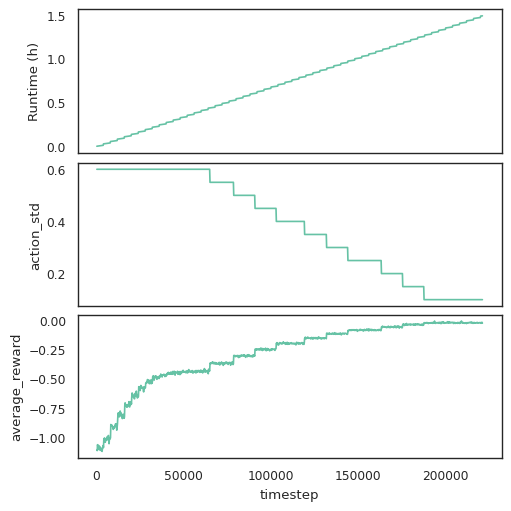

In [5]:
# Load history from wandb
history = run.history(samples=2000)
history['timestep'] = history['end_timestep']
history['Runtime (h)'] = history['_runtime'] / 60**2

# Plot
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True, layout='constrained')
axs = axs.flatten()
sns.lineplot(history, x='timestep', y='Runtime (h)', ax=axs[0])
sns.lineplot(history, x='timestep', y='action_std', ax=axs[1])
sns.lineplot(history, x='timestep', y='average_reward', ax=axs[2])
plt.show()

### Animate Latent Space

In [6]:
%matplotlib agg

# Simulate to completion
env.reset(); recording = defaultdict(lambda: [])
recording['states'].append(env.get_state().cpu())
recording['rewards'].append(0)
for _ in range(400):
    state = env.get_state(include_modalities=True)
    self_entity = state
    idx = torch.zeros((num_nodes, num_nodes), dtype=torch.bool)
    for i, j in itertools.product(*[range(x) for x in idx.shape]):
        idx[i, j] = i!=j
    node_entities = state.unsqueeze(0).expand(num_nodes, *state.shape)
    node_entities = node_entities[idx].reshape(num_nodes, num_nodes-1, run.config['policy/num_features_per_node'])
    rewards, finished = env.step(policy.act(self_entity, node_entities).detach())
    recording['states'].append(env.get_state().cpu())
    recording['rewards'].append(rewards.cpu().mean().item())
    if finished: break

# Create figure
fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
sct = ax.scatter(*recording['states'][0][:, :2].T)

# Update function
def update(frame):
    sct.set_offsets(recording['states'][frame][:, :2])
    ax.set_title(recording['rewards'][frame])
    ax.set_aspect('equal')
    ax.set_xlim([-env.pos_bound-.2, env.pos_bound+.2])
    ax.set_ylim([-env.pos_bound-.2, env.pos_bound+.2])

    return sct

# Run animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(recording['states']), interval=1e3*env.delta/10)
ani.save(os.path.join(PLOT_FOLDER, 'sample.gif'), writer='pillow')
display.HTML(ani.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.
